In [1]:
import json
from pprint import pprint
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import torch
import sys
sys.path.append(r'C:\Study\SpeechAcquisitionModel')
from src.reinforcement.goal_directed_model_based_rl.model import SimpleStochasticActorCritic,\
    SimpleStochasticModelDynamics, SimpleDeterministicPolicy, SimpleDeterministicModelDynamics, EnsembleDeterministicModelDynamicsDeltaPredict
from src.reinforcement.goal_directed_model_based_rl.env import VTLEnvWithReferenceTransitionMaskedEntropyScore
from src.reinforcement.goal_directed_model_based_rl.algs.model_based_multi_step_backprop_with_ensemble_classifier import ModelBasedMultiStepBackPropWithEnsembleClassifier
from src.speech_classification.pytorch_conv_lstm import LstmNet, LstmNetEnsemble


In [2]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [3]:
model_dir = r'C:\Study\SpeechAcquisitionModel\reports\videos\\video_ensemble_multi_step_V2_05_28_2019_10_53_AM'

In [4]:
with open(model_dir+ '/config.json') as data_file:
    kwargs = json.load(data_file)

In [5]:
device = 'cpu'
kwargs['mbbackprop']['device'] = device

speaker_fname = os.path.join(kwargs['env']['vtl_dir'], 'JD2.speaker')

lib_path = os.path.join(kwargs['env']['vtl_dir'], 'VocalTractLab2.dll')

env = VTLEnvWithReferenceTransitionMaskedEntropyScore(lib_path, speaker_fname, **kwargs['env'])
env.reset(train_mode=True)

Compile date of the library: "Mar  6 2019"


array([ 2.66517292e-01, -4.23394096e+00,  0.00000000e+00, -4.39989107e+00,
        8.91013641e-02,  1.07782053e+00,  9.99429576e-01,  4.66974654e-02,
        1.55039778e-02, -1.15259205e-01, -1.87878533e+00,  4.20619675e+00,
       -1.58131052e+00,  3.14065347e+00, -6.67073289e-01, -2.77509133e+00,
       -3.11807543e+00,  1.37406547e+00, -1.67344428e-01,  6.30115722e-01,
        9.01040221e-02, -5.00000000e-02, -4.34483654e-02, -3.91177799e-02,
        7.27681908e-05,  1.32995546e-04,  1.14248111e-04,  1.39637874e-04,
        1.22991479e-04,  4.64118580e-03,  4.58443187e-03,  1.16642541e-03,
        4.19522735e-03,  3.92310205e-03,  9.30392902e-05,  2.34976759e-05,
        2.78637361e-05,  2.22857442e-04,  1.73687763e-03,  5.60114360e-04,
        3.12718085e-04,  9.17579756e-05,  3.15906863e-05,  1.19164185e-05,
        1.28892520e-05,  1.56153632e-05,  1.66095390e-05,  1.81796439e-05,
        2.00374550e-05,  2.23670787e-05,  2.75482836e-01, -4.24338773e+00,
       -1.10512677e-02, -

In [6]:
model_dynamics = torch.load(model_dir + '/model_dynamics.pickle')
agent = torch.load(model_dir + '/agent.pickle')


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


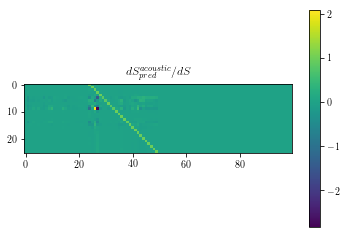

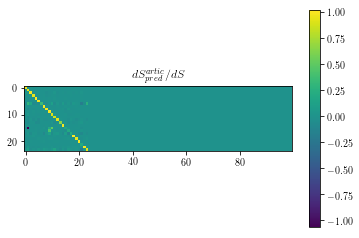

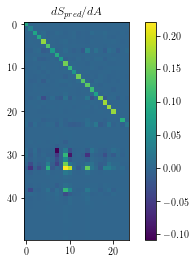

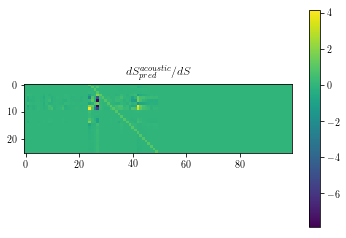

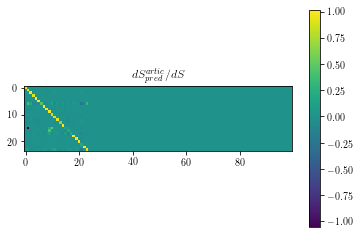

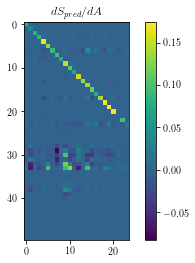

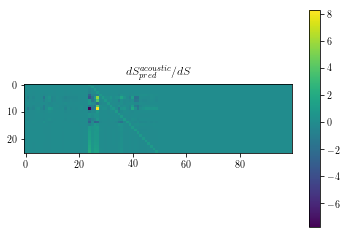

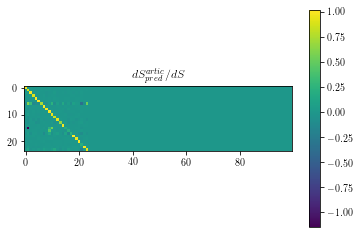

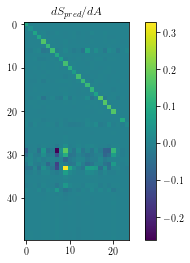

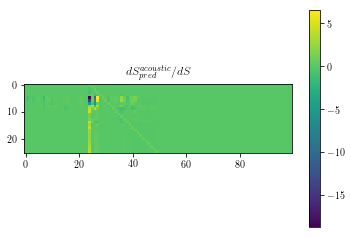

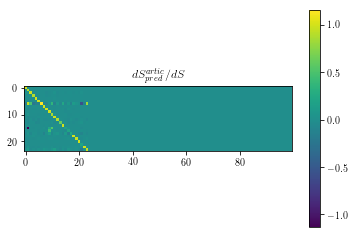

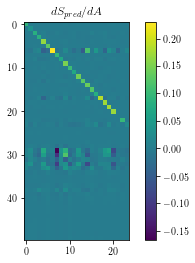

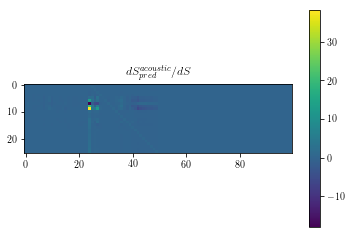

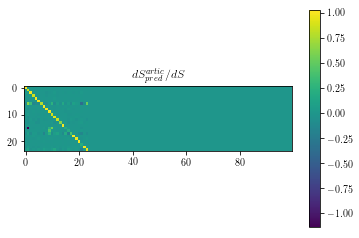

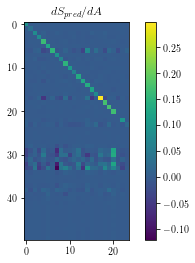

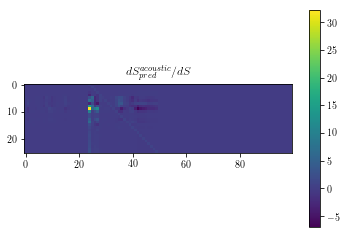

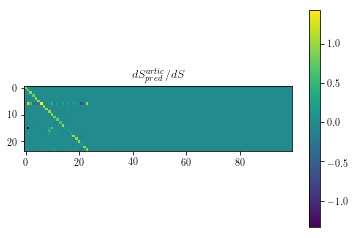

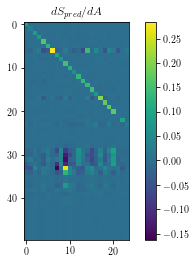

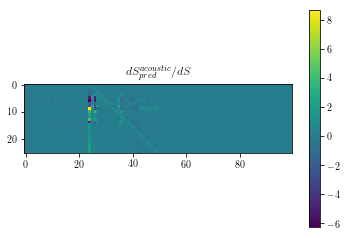

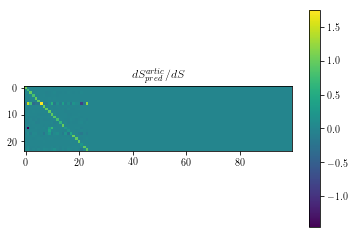

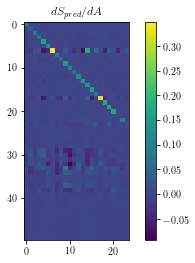

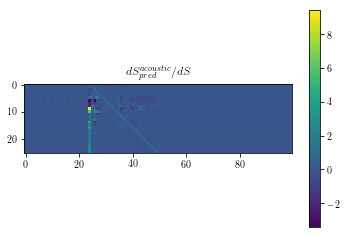

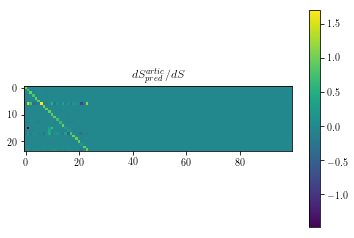

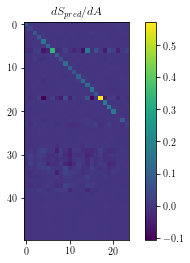

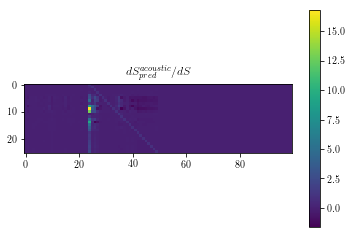

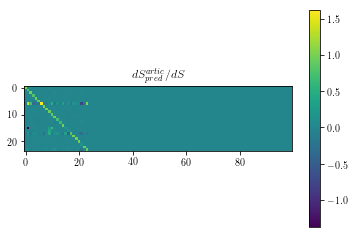

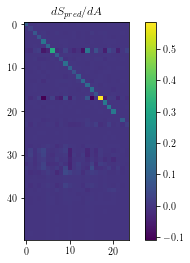

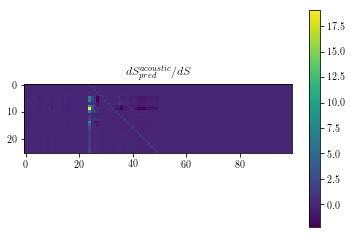

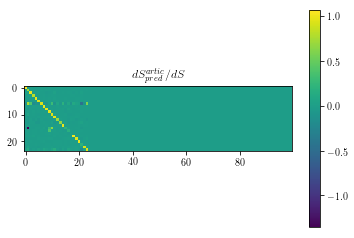

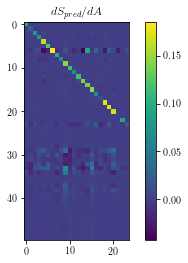

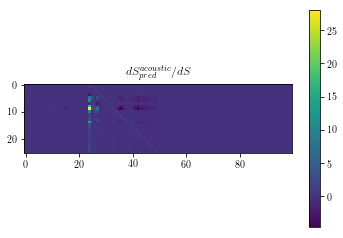

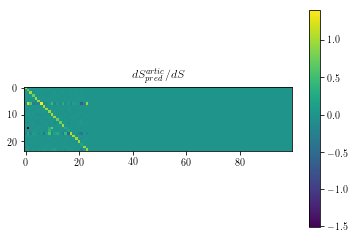

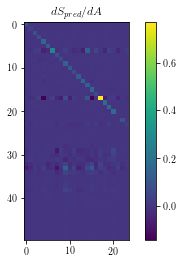

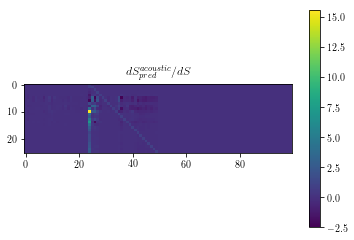

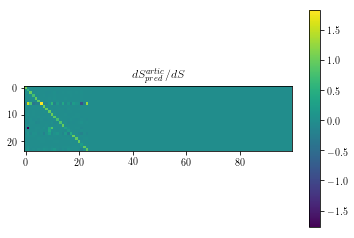

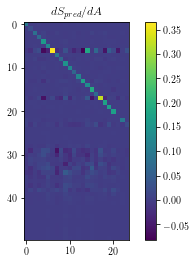

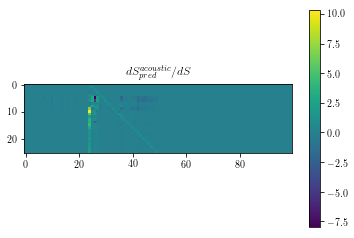

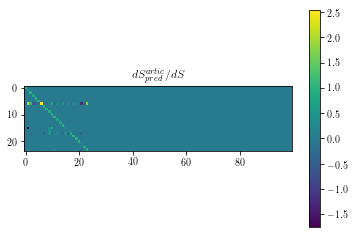

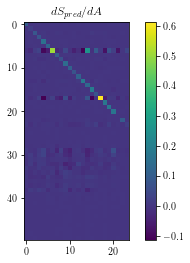

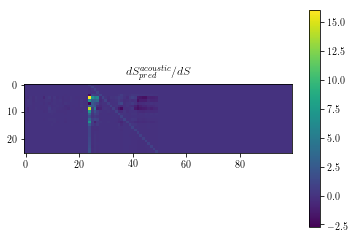

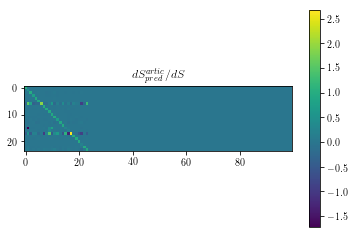

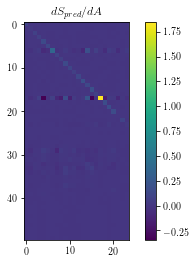

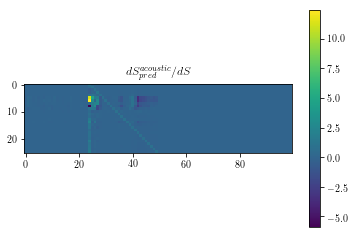

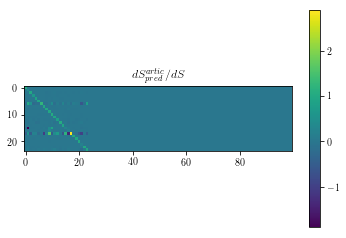

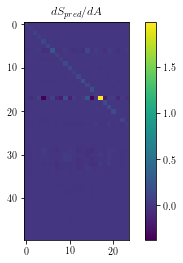

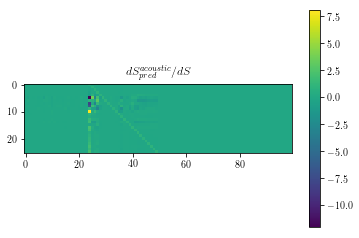

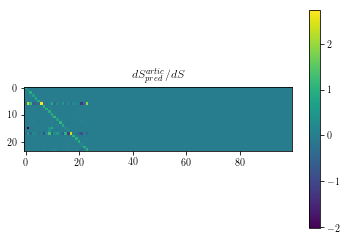

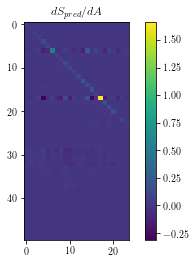

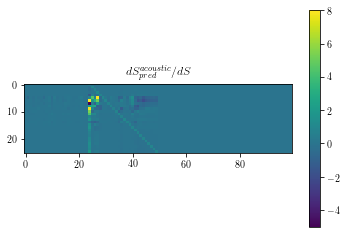

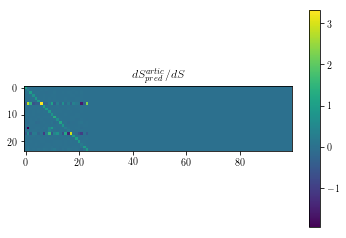

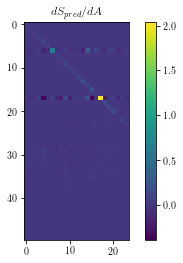

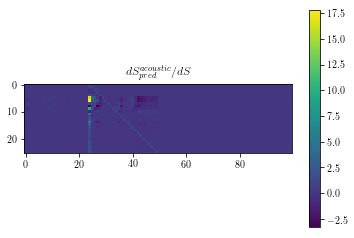

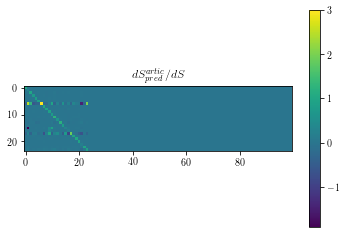

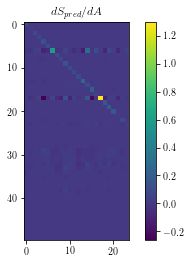

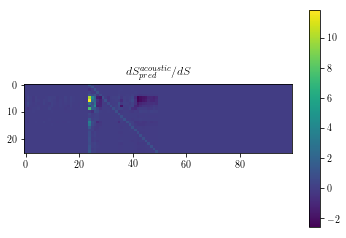

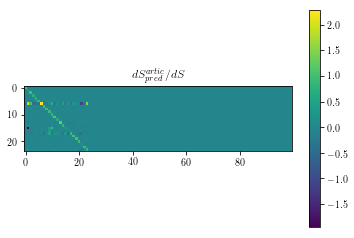

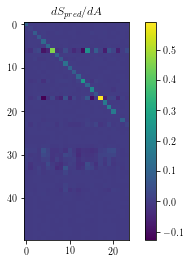

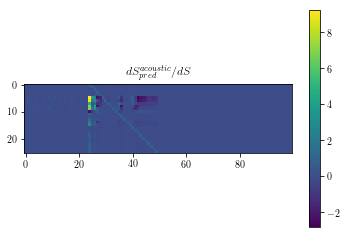

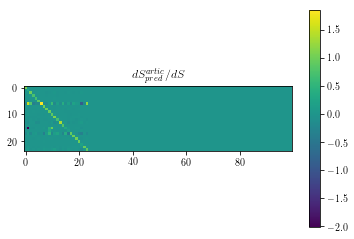

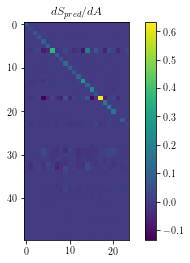

In [7]:
ep_states = []
ep_states_pred = []
ep_states_std_pred = []
ep_actions = []
misses = []

T = len(env.get_current_reference())
state0 = env.reset()
state = state0
env.render()
state = env.normalize(state, env.state_bound)
ep_states.append(state)
ep_states_pred.append(state[:-env.goal_dim])


# axes[0].cla()

score = 0.

agent.eval()
model_dynamics.eval()
step = 0
terminated = False

probs = []
entropies = []

while True:
    state_tensor = torch.tensor(torch.from_numpy(state).float().to(device).view(1, -1), requires_grad=True)
    action = agent(state_tensor).detach().cpu().numpy().squeeze()
    ep_actions.append(action)
    action_denorm = env.denormalize(action, env.action_bound)
    next_state, reward, done, _ = env.step(action_denorm)

    probs.append(reward[0].detach().cpu().numpy())
    entropies.append(reward[1].detach().cpu().numpy())

    action_tensor = torch.tensor(torch.from_numpy(action).float().to(device).view(1,-1), requires_grad=True)
    
    next_state_pred, next_state_pred_std, _ = model_dynamics(state_tensor, action_tensor)
    
    
    saliency_state = []    
    saliency_action = []

    for d in range(next_state_pred.shape[-1]):
#         state_tensor.grad.data.zero_()
#         next_state_pred[:, d].backward(retain_graph=True)
        grad = torch.autograd.grad(next_state_pred[:, d], state_tensor, retain_graph=True)
#         grad = state_tensor.grad.data.detach().numpy()
        saliency_state.append(grad[0].numpy())
    
        grad1 = torch.autograd.grad(next_state_pred[:, d], action_tensor, retain_graph=True)
        saliency_action.append(grad1[0].numpy())
    
    
#         state_tensor.grad.data.zero_()
    saliency_state = np.array(saliency_state).squeeze()
    plt.imshow(saliency_state[-26:, :])
    plt.colorbar()
    plt.title(r'$d S_{pred}^{acoustic} /  dS $')
    plt.show()
    
    saliency_state = np.array(saliency_state).squeeze()
    plt.imshow(saliency_state[:-26, :])
    plt.colorbar()
    plt.title(r'$d S_{pred}^{artic} /  dS $')
    plt.show()
    
    saliency_action = np.array(saliency_action).squeeze()
    plt.imshow(saliency_action)
    plt.colorbar()
    plt.title(r'$d S_{pred} /  dA $')
    plt.show()
    
    next_state = env.normalize(next_state, env.state_bound)
    
    ep_states.append(next_state)
    ep_states_pred.append(next_state_pred.detach().cpu().numpy().squeeze())
    ep_states_std_pred.append(next_state_pred_std.detach().cpu().numpy().squeeze())
    
    next_state_pred = env.denormalize(next_state_pred.detach().cpu().numpy().squeeze(), env.state_bound[:-env.goal_dim])

    
    
    
    env.render()
    
    miss = torch.abs(torch.from_numpy(next_state).float().to(device)[:-env.goal_dim][torch.from_numpy(np.array(env.state_goal_mask, dtype=np.uint8)).byte()] -
                     torch.from_numpy(state).float().to(device)[-env.goal_dim:])

    misses.append(miss[:].max().detach().cpu().numpy())

    if len(misses) > 3 and np.all(np.array(misses[-3:]) > 0.1) and not terminated:
        terminated = True
        res_step = step
        miss_max_idx = np.argmax(miss[:].detach().cpu().numpy())
    elif not terminated:
        score = step
   
    if np.any(done):

        break
    state = next_state
    step += 1

(21, 100)
(21, 50)


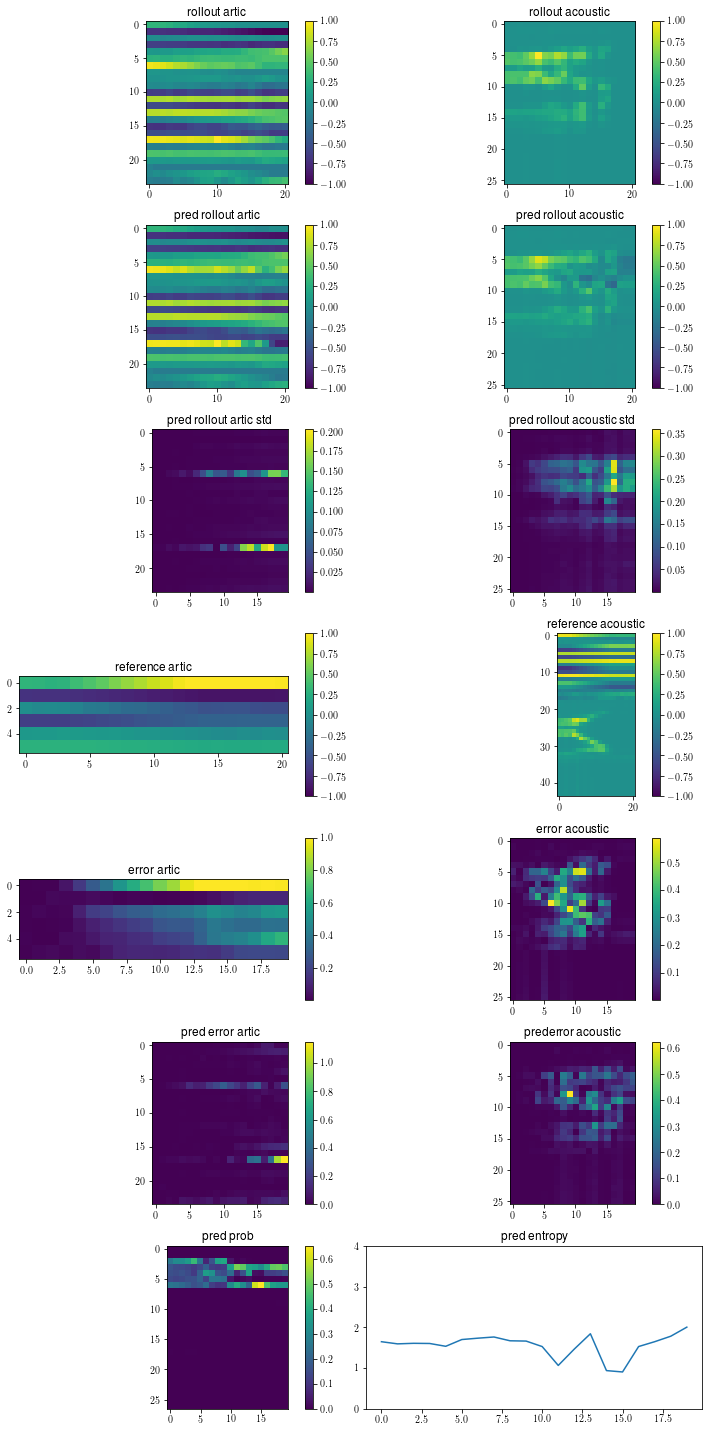

In [8]:
n_audio = 26
n_artic = 24
n_artic_goal = 6


# Share a X axis with each column of subplots
fig, axes = plt.subplots(7, 2, figsize=(10, 20))
cb = None
# plt.ion()
# plt.show()



# ep_states = env.normalize(np.array(ep_states), env.state_bound)
ep_states = np.array(ep_states)
im0 = axes[0, 0].imshow(np.array(ep_states)[:, :n_artic].T, vmin=-1., vmax=1.)
axes[0, 0].set_title('rollout artic')
plt.colorbar(im0, ax=axes[0, 0])

im0 = axes[0, 1].imshow(np.array(ep_states)[:, n_artic: n_artic+n_audio].T, vmin=-1., vmax=1.)
axes[0, 1].set_title('rollout acoustic')
plt.colorbar(im0, ax=axes[0, 1])
# im_pred = axes[1].imshow(np.array(ep_states_pred)[:, -n_audio:].T, vmin=vmin, vmax=vmax)

im_pred = axes[1, 0].imshow(np.array(ep_states_pred)[:, :n_artic].T, vmin=-1., vmax=1.)
axes[1, 0].set_title('pred rollout artic')
plt.colorbar(im_pred, ax=axes[1, 0])

im_pred = axes[1, 1].imshow(np.array(ep_states_pred)[:, n_artic: n_artic+n_audio].T, vmin=-1., vmax=1.)
axes[1, 1].set_title('pred rollout acoustic')
plt.colorbar(im_pred, ax=axes[1, 1])

im_pred = axes[2, 0].imshow(np.array(ep_states_std_pred)[:, :n_artic].T)
axes[2, 0].set_title('pred rollout artic std')
plt.colorbar(im_pred, ax=axes[2, 0])

im_pred = axes[2, 1].imshow(np.array(ep_states_std_pred)[:, n_artic: n_artic+n_audio].T)
axes[2, 1].set_title('pred rollout acoustic std')
plt.colorbar(im_pred, ax=axes[2, 1])

if n_artic_goal > 0:
    im1 = axes[3, 0].imshow(ep_states[:, -env.goal_dim: -env.goal_dim + n_artic_goal].T, vmin=-1., vmax=1.)
    axes[3, 0].set_title('reference artic')
    plt.colorbar(im1, ax=axes[3, 0])

im1 = axes[3, 1].imshow(ep_states[:, -env.goal_dim + n_artic_goal:].T, vmin=-1., vmax=1.)
axes[3, 1].set_title('reference acoustic')
plt.colorbar(im1, ax=axes[3, 1])

diff_img = np.abs(np.array([ep_states[i, -env.goal_dim:] - np.array(ep_states)[i + 1, :-env.goal_dim][env.state_goal_mask] for i in range(len(ep_states)-1)]))
# diff_img_normed = env.normalize(diff_img.T, env.state_bound[:-env.goal_dim])
diff_img_normed = diff_img

if n_artic_goal > 0:
    im2 = axes[4, 0].imshow(np.array(diff_img_normed[:, :n_artic_goal].T))
    axes[4, 0].set_title('error artic')
    plt.colorbar(im2, ax=axes[4, 0])

im2 = axes[4, 1].imshow(np.array(diff_img_normed[:, -n_audio:].T))
axes[4, 1].set_title('error acoustic')
plt.colorbar(im2, ax=axes[4, 1])

print(ep_states.shape)
print(np.array(ep_states_pred).shape)

pred_err_img = np.abs(np.array(
    [ep_states[i, :-env.goal_dim] - np.array(ep_states_pred)[i, :] for i in
     range(len(ep_states) - 1)]))
# diff_img_normed = env.normalize(diff_img.T, env.state_bound[:-env.goal_dim])
im3 = axes[5, 0].imshow(np.array(pred_err_img[:, :n_artic].T))
axes[5, 0].set_title('pred error artic')
plt.colorbar(im3, ax=axes[5, 0])

im3 = axes[5, 1].imshow(np.array(pred_err_img[:, n_artic:n_artic + n_audio].T))
axes[5, 1].set_title('prederror acoustic')
plt.colorbar(im3, ax=axes[5, 1])

im4 = axes[6, 0].imshow(np.array(probs).T, vmin=0., vmax=np.array(probs).T.max())
# axes[5, 1].ylim((0, 1.0))
axes[6, 0].set_title('pred prob')
plt.colorbar(im4, ax=axes[6, 0])

im4 = axes[6, 1].plot(np.array(entropies))
axes[6, 1].set_ylim(bottom=0, top=np.array(entropies).max()+2)
axes[6, 1].set_title('pred entropy')
# plt.colorbar(im4, ax=axes[4, 1])

# if cb is None:
# cb = plt.colorbar(im0, ax=axes[0, 1])
# plt.colorbar(im_pred, ax=axes[1, 1])
# plt.colorbar(im1, ax=axes[2, 1])
# plt.colorbar(im2, ax=axes[3, 1])
# plt.colorbar(im3, ax=axes[4, 1])
plt.tight_layout()
# plt.draw()
# plt.pause(.001)
plt.show()